In [1]:
import pandas as pd
from tqdm import tqdm
import json
import os
import umap
import numpy as np
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix


import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN

import warnings
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, constraints, regularizers
from tensorflow.keras.layers import Input, Layer, Lambda, Dropout, Reshape, Dense
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, optimizers, losses, metrics, Model
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In /Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be re

## Graph Convolutional Networks

In the previous blogs we've looked at graph embedding methods that tried to capture the neighbourhood and some structural information from graphs. While these methods were quite successful in representing the nodes, they could not incorporate node features into these embeddings. For some tasks this information might be crucial, so today we'll cover Graph Convolutional Networks (GCN) which can use both - graph and node feature information. As you could guess from the name, GCN is a neural network architecture that works with graph data. The main goal of GCN is to distill graph and node attribute information into the vector node representation aka embeddings. Below, I'll explore how GCNs manage to achieve this and will apply this method to classify Github developers into web or ML engineers. 

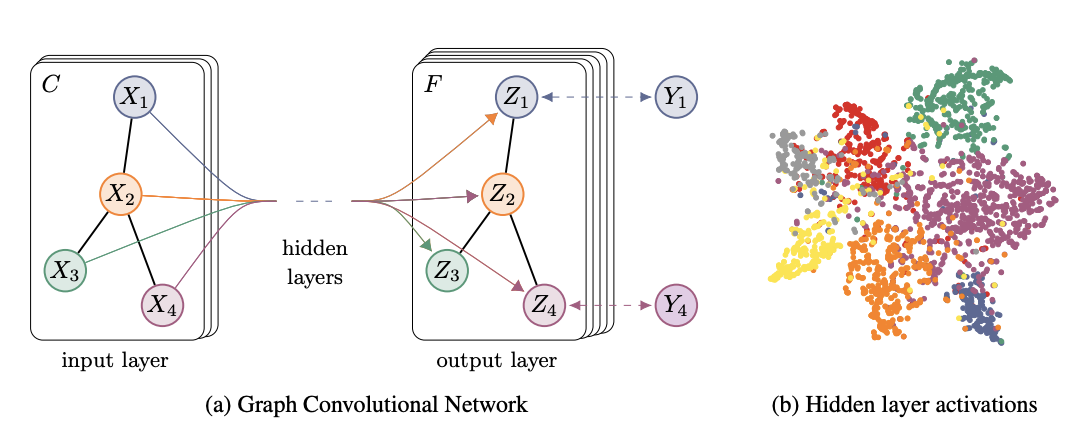

For this blog, I'll be heavily using `stellargraph` library ([docs](https://stellargraph.readthedocs.io/en/stable/)) and their implementation of GCN. They provide excellent working notebooks [here](https://stellargraph.readthedocs.io/en/stable/demos/node-classification/gcn-node-classification.html), so if you're just interested in applying these methods, feel free to read their own notebooks instead. For this article, my goal is to dive under the hood of GCNs and provide some intuition into what is happening in each layer.

## Data

Let's start by reading in data. Similar to the previous blogs, I'll be using github dataset from this [repository](https://github.com/benedekrozemberczki/datasets), so make sure to download the data and star the repository. We're going to classify github users into web or ML developers. In this dataset, nodes are github developers who have starred more than 10 repositories, edges represent mutual following, and features are based on location, starred repositories, employer, and email. 

### Read in edges, features, and targets

In [2]:
edges_path = 'datasets-master/git_web_ml/git_edges.csv'
targets_path = 'datasets-master/git_web_ml/git_target.csv'
features_path = 'datasets-master/git_web_ml/git_features.json'

In [3]:
# Read in edges
edges = pd.read_csv(edges_path)
edges.columns = ['source', 'target'] # renaming for StellarGraph compatibility
display(edges.shape, edges.head())

(289003, 2)

,source,target
0,0,23977
1,1,34526
2,1,2370
3,1,14683
4,1,29982


In [4]:
# Read in features
with open(features_path) as json_data:
    features = json.load(json_data)
    
max_feature = np.max([v for v_list in features.values() for v in v_list])
features_matrix = np.zeros(shape = (len(list(features.keys())), max_feature+1))

i = 0
for k, vs in tqdm(features.items()):
    for v in vs:
        features_matrix[i, v] = 1
    i+=1

100%|██████████| 37700/37700 [00:00<00:00, 57768.12it/s]


In [5]:
node_features = pd.DataFrame(features_matrix, index = features.keys())
display(node_features.shape, node_features.head())

(37700, 4005)

,0,1,2,3,4,5,6,7,8,9,...,3995,3996,3997,3998,3999,4000,4001,4002,4003,4004
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Read in targets
targets = pd.read_csv(targets_path)
targets.index = targets.id.astype(str)
targets = targets.loc[features.keys(), :]
display(targets.shape, targets.head(), targets.ml_target.value_counts(normalize=True))

(37700, 3)

,id,name,ml_target
id,,,
0,0,Eiryyy,0
1,1,shawflying,0
2,2,JpMCarrilho,1
3,3,SuhwanCha,0
4,4,sunilangadi2,1


0    0.741671
1    0.258329
Name: ml_target, dtype: float64

So, we have 37700 developers, 289003 mutual followership and 4005 features per node. About 75% of users are web developers and 25% are ML developers.

### StellarGraph Data

`stellargraph` has its own graph data structure that has a lot of cool functionalities and is required to work with their API. Transforming your data into StellarGraph is really simple, you just provide the node features and edges dataframes to the `StellarGraph` function. This data type also supports weighted edges, heterogeneous node and edge types, and directed graphs. 

In [7]:
G = sg.StellarGraph(node_features, edges.astype(str))

In [8]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 37700, Edges: 289003

 Node types:
  default: [37700]
    Features: float32 vector, length 4005
    Edge types: default-default->default

 Edge types:
    default-default->default: [289003]
        Weights: all 1 (default)
        Features: none


### Train/Test/Val split

Since we're working with neural networks, we'll need to create 3 datasets - training, validation, and testing. GCN is a semi-supervised model meaning that it needs significantly less labels than purely supervised models (e.g. Random Forest). So, let's imaging the we have only 1% of data labeled which is about 400 developers. We're going to use 200 developers for training, and 200 developers for validation in this scenario. Everything else will be used for testing.

In [9]:
train_pages, test_pages = train_test_split(targets, train_size=200)
val_pages, test_pages = train_test_split(test_pages, train_size=200)

In [10]:
train_pages.shape, val_pages.shape, test_pages.shape

((200, 3), (200, 3), (37300, 3))

## Pre-processing

### Target pre-processing

In [13]:
target_encoding = LabelBinarizer()

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])

### Graph Data Pre-processing

This part is key for GCNs to work. To understand what kind of pre-processing we need to do, let's take a look at what the Graph Convolutional Layer will be doing. What we want is to somehow aggregate the feature information from the neighbouring nodes because we want to learn the embeddings that reflect graph neighbourhoods. In Convolutional Neural Networks, which are usually used for image data, this is achieved using convolution operations with pixels and kernels. The pixel intensity of neighbouring nodes (e.g. 3x3) gets passed through the kernel that averages the pixels into a single value. It works well with image data because the neighbours are ordered and fixed in size. We don't have these qualities with graphs so we need to come up with an alternative.

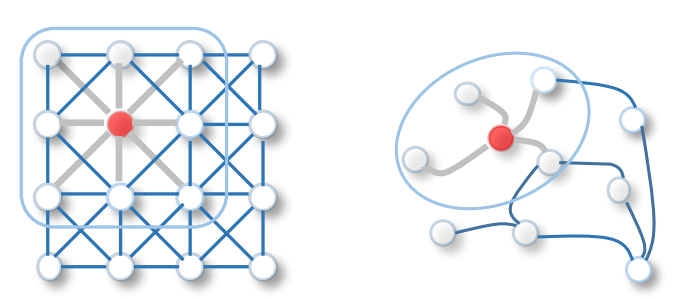

The alternative is to use the idea of information passing by multiplying the hidden state by the adacency matrix. If you recall from this [post](https://antonsruberts.github.io/graph/label_propagation/) about label propagation, adjacency matrix denotes connections between the nodes. Hence, by multiplying the hidden state (or node features in the first layer) by it, we are sort of applying a mask and aggregating only the information from neighbouring nodes. Zak Jost has made a [great video](https://www.youtube.com/watch?v=ijmxpItkRjc&t=524s) explaining these concepts in detail, so if you're a bit unclear about why we need to multiply by the adjacency matrix, make sure to check out his video.

More formally, the Graph Convolutional Layer can be expressed using this equation: 

\begin{equation} 
H^{(l+1)} = \sigma(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}{H^{(l)}}{W^{(l)}})
\end{equation}

In this equation:
* $H$ - hidden state (or node attributes when $l$ = 0)
* $\tilde{D}$ - degree matrix
* $\tilde{A}$ - adjacency matrix (with self-loops)
* $W$ - trainable weights
* $\sigma$ - activation function
* ${l}$ - layer number 

As you can see, there are 2 parts of this equation - non-trainable (with D, A) and trainable (with H, A). The non-trainable part is called the normalised adjacency matrix and we'll see how to calculate it below. You might have noticed that if we remove the non-trainable part, we're left with simple dense layer. By multiplying hidden state with the normalised adjacency matrix, we are aggregating the neighbouring features as discussed above. The final question to answer is - why do we need to normalise the adjacency matrix? The intuitive explanation is that we want to discount the "contribution" of node features (or hidden states) from the highly connected nodes, as they are not that important. More formally, putting the adjacency matrix between two $\tilde{D}^{1/2}$ results in scaling each adjacency value by ${1/\sqrt{{D_i}{D_j}}}$ where $i$ and $j$ are some connected nodes. Hence, when the connected nodes have a lot of other connections (i.e. $D$ is large), features get multiplied by a smaller value and are dicounted.

Our task now is to pre-compute the non-trainable part, so let's see how to do it. `stellargraph` implements these computations in sparse format because of speed, so we'll follow their step and use their implementation.

In [12]:
# Get the adjacency matrix
A = G.to_adjacency_matrix(weighted=False)

# Add self-connections
A_t = A + sp.diags(np.ones(A.shape[0]) - A.diagonal())

# Degree matrix to the power of -1/2
D_t = sp.diags(np.power(np.array(A.sum(1)), -0.5).flatten(), 0)

# Normalise the Adjacency matrix
A_norm = A.dot(D_t).transpose().dot(D_t).todense()

Great, now you know how to pre-process the data for your GCN. There's a couple more formalities we need to take care of before modelling:
1. Get the new indices of train, val and test sets - required by model to calculate loss
2. Add a dimension to our data - required by Keras to properly work

In [13]:
# Define the function to get these indices
def get_node_indices(G, ids):
    # find the indices of the nodes
    node_ids = np.asarray(ids)
    flat_node_ids = node_ids.reshape(-1)

    flat_node_indices = G.node_ids_to_ilocs(flat_node_ids) # in-built function makes it really easy
    # back to the original shape
    node_indices = flat_node_indices.reshape(1, len(node_ids)) # add 1 extra dimension
    
    return node_indices

train_indices = get_node_indices(G, train_pages.index)
val_indices = get_node_indices(G, val_pages.index)
test_indices = get_node_indices(G, test_pages.index)

In [14]:
# Expand dimensions
features_input = np.expand_dims(features_matrix, 0)
A_input = np.expand_dims(A_norm, 0)

y_train = np.expand_dims(train_targets, 0)
y_val = np.expand_dims(val_targets, 0)
y_test = np.expand_dims(test_targets, 0)

Now that data is normalised and in the right shape, we can move to modelling.

## GCN Model

As you can see in the equation above, the GCN layer is nothing more but the multiplication of inputs, weights, and the normalised adjacency matrix. You can see this in the implementation of `stellargraph`'s `GraphConvolution` layer on [github](https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/layer/gcn.py) in lines 208 and 209. Since we know now what happens under the hood, let's simply import the layer and use it in our architecture. 

In [15]:
from stellargraph.layer.gcn import GraphConvolution, GatherIndices

In [16]:
# Initialise GCN parameters
kernel_initializer="glorot_uniform"
bias = True
bias_initializer="zeros"
n_layers = 2
layer_sizes = [32, 32]
dropout = 0.5
n_features = features_input.shape[2]
n_nodes = features_input.shape[1]

First of all, let's initialise the Input layers with the correct shapes to receive our 3 inputs:
1. Features matrix
2. Train/Val/Test indices 
3. Normalised adjacency matrix

In [17]:
x_features = Input(batch_shape=(1, n_nodes, n_features))
x_indices = Input(batch_shape=(1, None), dtype="int32")
x_adjacency = Input(batch_shape=(1, n_nodes, n_nodes))
x_inp = [x_features, x_indices, x_adjacency]
x_inp

[<KerasTensor: shape=(1, 37700, 4005) dtype=float32 (created by layer 'input_1')>,
 <KerasTensor: shape=(1, None) dtype=int32 (created by layer 'input_2')>,
 <KerasTensor: shape=(1, 37700, 37700) dtype=float32 (created by layer 'input_3')>]

Now, we can build a model with 2 GCN dropout layers. Each layer will have 32 nodes which should be enough to transform the data into useful embeddings.

In [19]:
x = Dropout(0.5)(x_features)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])
x = Dropout(0.5)(x)
x = GraphConvolution(32, activation='relu', 
                     use_bias=True,
                     kernel_initializer=kernel_initializer,
                     bias_initializer=bias_initializer)([x, x_adjacency])

x = GatherIndices(batch_dims=1)([x, x_indices])
output = Dense(1, activation='sigmoid')(x)

In [20]:
model = Model(inputs=[x_features, x_indices, x_adjacency], outputs=output)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(1, 37700, 4005)]   0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (1, 37700, 4005)     0           input_1[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(1, 37700, 37700)]  0                                            
__________________________________________________________________________________________________
graph_convolution_2 (GraphConvo (1, 37700, 32)       128192      dropout_2[0][0]                  
                                                                 input_3[0][0]                

In [21]:
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

In [45]:
es_callback = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

In [24]:
history = model.fit(
    x = [features_input, train_indices, A_input],
    y = y_train,
    batch_size = 32,
    epochs=200,
    validation_data=([features_input, val_indices, A_input], y_val),
    verbose=1,
    shuffle=False,
    callbacks=[es_callback],
)

Epoch 1/200
1/1 [==============================] - 198s 198s/step - loss: 0.6941 - acc: 0.4400 - val_loss: 0.6409 - val_acc: 0.7750
Epoch 2/200
1/1 [==============================] - 95s 95s/step - loss: 0.6443 - acc: 0.7200 - val_loss: 0.5901 - val_acc: 0.7750
Epoch 3/200
1/1 [==============================] - 98s 98s/step - loss: 0.6011 - acc: 0.7200 - val_loss: 0.5447 - val_acc: 0.7750
Epoch 4/200
1/1 [==============================] - 98s 98s/step - loss: 0.5575 - acc: 0.7200 - val_loss: 0.5129 - val_acc: 0.7750
Epoch 5/200
1/1 [==============================] - 109s 109s/step - loss: 0.5320 - acc: 0.7200 - val_loss: 0.5031 - val_acc: 0.7750
Epoch 6/200
1/1 [==============================] - 105s 105s/step - loss: 0.5229 - acc: 0.7200 - val_loss: 0.5026 - val_acc: 0.7750
Epoch 7/200
1/1 [==============================] - 100s 100s/step - loss: 0.5115 - acc: 0.7200 - val_loss: 0.4909 - val_acc: 0.7750
Epoch 8/200
1/1 [==============================] - 107s 107s/step - loss: 0.4825 -

## Model Evaluation
Now that we have the trained model, let's evaluate its accuracy on the test set we've set aside.

In [25]:
test_preds = model.predict([features_input, test_indices, A_input])

In [27]:
def evaluate_preds(true, pred):
    auc = roc_auc_score(true, pred)
    pr = average_precision_score(true, pred)
    bin_pred = [1 if p > 0.5 else 0 for p in pred]
    f_score = f1_score(true, bin_pred)
    print('ROC AUC:', auc)
    print('PR AUC:', pr)
    print('F1 score:', f_score)
    print(confusion_matrix(true, bin_pred, normalize='true'))
    
    return auc, pr, f_score
    



In [42]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),test_preds[0].ravel())

ROC AUC: 0.8855380533388334
PR AUC: 0.7430231163326726
F1 score: 0.6831320233159065
[[0.95231726 0.04768274]
 [0.41025109 0.58974891]]


We're getting a ROC AUC score of 0.89 with just 200 labelled examples, not bad at all. Let's visualise what the model has learned by accessing the embeddings before the classification layer. 

In [54]:
embedding_model = Model(inputs=x_inp, outputs=model.layers[-2].output)
all_indices = get_node_indices(G, targets.index)
emb = embedding_model.predict([features_input, all_indices, A_input])
emb.shape

(1, 37700, 32)

In [55]:
u = umap.UMAP(random_state=42)
umap_embs = u.fit_transform(emb[0])

/Users/antonsruberts/miniconda/envs/ravelin36/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


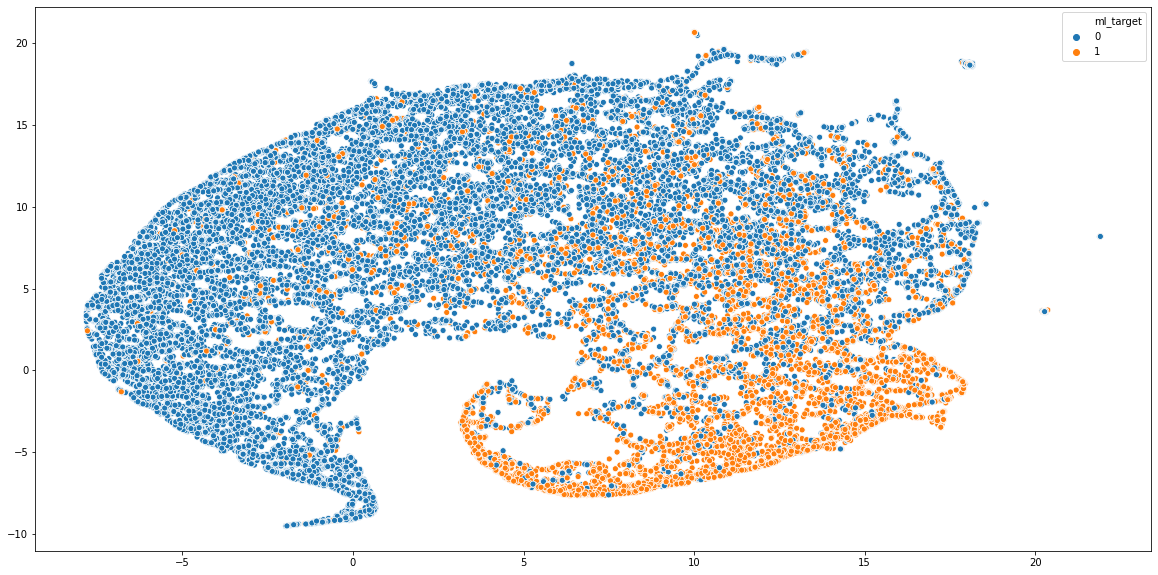

In [57]:
plt.figure(figsize=(20,10))
ax = sns.scatterplot(x = umap_embs[:, 0], y = umap_embs[:, 1], hue = targets['ml_target'])

As you can see, two classes are quite distinctly clustered in the opposite sides of the graph. Yet, there's some degree of mixing in the center of the plot, which can be expected because ML and web developers still have a lot in common. 

## RF Baseline

We can also put the results of GCN into perspective by training and evaluating a Random Forest model trained with the same samples.

In [11]:
from sklearn.ensemble import RandomForestClassifier

In [32]:
rf = RandomForestClassifier()

rf.fit(node_features.loc[train_pages.index, :], train_targets.ravel())

test_preds = rf.predict_proba(node_features.loc[test_pages.index, :])[:, 1]
evaluate_preds(test_targets.ravel(), test_preds)

ROC AUC: 0.8409632000657918
PR AUC: 0.7091492821465811
F1 score: 0.5649756298482873
[[0.96987212 0.03012788]
 [0.57215637 0.42784363]]


(0.8409632000657918, 0.7091492821465811, 0.5649756298482873)

Using the GCN we get about 0.04 increase to the ROC-AUC and PR-AUC which means that the graph data indeed adds useful information to the classification problem. Let's see what now what would be the performance if we had more labelled data avaliable. 

## Adding More Data

To make these experiments faster and less complicated, let's now use the StellarGraph API fully. Since you understand what's happening under the hood, there's nothing wrong with making your life easier! We're going to run the experiment with 1000 labelled nodes but feel free to choose your own parameters here.

In [33]:
# 1000 training examples
train_pages, test_pages = train_test_split(targets, train_size=1000)
val_pages, test_pages = train_test_split(test_pages, train_size=500)

train_targets = target_encoding.fit_transform(train_pages['ml_target'])
val_targets = target_encoding.transform(val_pages['ml_target'])
test_targets = target_encoding.transform(test_pages['ml_target'])


Remember all the preprocessing we had to do above? Well, StellarGraph actually takes care of this for you. All you need to do is to initialise and use the `BatchGenerator` object.

In [36]:
# Initialise the generator
generator = FullBatchNodeGenerator(G, method="gcn")

# Use the .flow method to prepare it for use with GCN
train_gen = generator.flow(train_pages.index, train_targets)
val_gen = generator.flow(val_pages.index, val_targets)
test_gen = generator.flow(test_pages.index, test_targets)

Using GCN (local pooling) filters...


Building the GCN model is also extremely easy with `stellargraph`.

In [41]:
# Build necessary layers
gcn = GCN(
    layer_sizes=[32, 32], activations=["relu", "relu"], generator=generator, dropout=0.5
)

# Access the input and output tensors
x_inp, x_out = gcn.in_out_tensors()

# Pass the output tensor through the dense layer with sigmoid
predictions = layers.Dense(units=train_targets.shape[1], activation="sigmoid")(x_out)

In [43]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.binary_crossentropy,
    metrics=["acc"],
)

You can see that the `stellargraph` integrates with Keras very seamlessly which makes workng with it so straightforward. Now, we can train the model in the same way we did before. The only difference is that we don't need to worry about providing all the inputs to the model, as the `generator` objects take care of it.

In [59]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback],
)

Epoch 1/200
1/1 - 4s - loss: 0.2291 - acc: 0.9020 - val_loss: 0.2877 - val_acc: 0.9020
Epoch 2/200
1/1 - 4s - loss: 0.2227 - acc: 0.9110 - val_loss: 0.2937 - val_acc: 0.9040
Epoch 3/200
1/1 - 4s - loss: 0.2170 - acc: 0.9180 - val_loss: 0.2942 - val_acc: 0.9040
Epoch 4/200
1/1 - 4s - loss: 0.2086 - acc: 0.9200 - val_loss: 0.2935 - val_acc: 0.9000
Epoch 5/200
1/1 - 3s - loss: 0.1944 - acc: 0.9280 - val_loss: 0.2978 - val_acc: 0.9020
Epoch 6/200
1/1 - 3s - loss: 0.2048 - acc: 0.9220 - val_loss: 0.2989 - val_acc: 0.9020
Epoch 7/200
1/1 - 4s - loss: 0.1881 - acc: 0.9220 - val_loss: 0.3019 - val_acc: 0.9040
Epoch 8/200
1/1 - 3s - loss: 0.1781 - acc: 0.9330 - val_loss: 0.3110 - val_acc: 0.9000
Epoch 9/200
1/1 - 3s - loss: 0.1698 - acc: 0.9380 - val_loss: 0.3133 - val_acc: 0.8980
Epoch 10/200
1/1 - 4s - loss: 0.1720 - acc: 0.9370 - val_loss: 0.3074 - val_acc: 0.8940
Epoch 11/200
1/1 - 3s - loss: 0.1752 - acc: 0.9300 - val_loss: 0.3114 - val_acc: 0.8920


You might also notice that the trainign was a lot faster. Let's see if the results got any better.

In [60]:
new_preds = model.predict(test_gen)

In [61]:
auc, pr, f_score = evaluate_preds(test_targets.ravel(),new_preds[0].ravel())

ROC AUC: 0.8967718089804773
PR AUC: 0.7643095230146493
F1 score: 0.7103994490358128
[[0.92937979 0.07062021]
 [0.33722425 0.66277575]]


The test scores have imporved as expected, so adding more data can still lead to a better model.

## Conclusion

GCNs are a powerful deep neural network architecture that allows you to combine the feature and graph neighbourhood information. This is achieved by multiplying previous layer values by the normalised adjacency matrix which acts as a convolutional filter. As a result of this multiplication, the features of neighbouring nodes get aggregated and usefull embeddings can be learned using back-propagation as usual. 

I hope that by now you know not only how to apply GCNs to your data but also feel more confident about what's happening under the hood. Thank you for reading, and if you have any questions or comments, feel free to reach out using my email or LinkedIn. 